In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
from yellowbrick.regressor import PredictionError
import smogn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor, BaggingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor



In [2]:
pip install smogn lightgbm

Note: you may need to restart the kernel to use updated packages.


Import processed_data after the EDA process in Exploratory Data Analysis file.

In [3]:
df = pd.read_csv("processed_data.csv",sep=",",index_col=0)

In [4]:
df.head()

,average_rating,num_pages,ratings_count,text_reviews_count,publisher_average_rating,author_average_rating,number_occurrence,author_average_page,author_book_count,language_average_rating,publication_year,rate_occurrence,review_weight,rating_weight_,rate_per_pages
0,4.57,652,2095690,27591,4.06,4.55,2,902.00,6,3.93,2006.00,9.14,126090.87,9577303.30,2979.64
1,4.49,870,2153167,29221,4.06,4.55,1,902.00,6,3.93,2004.00,4.49,131202.29,9667719.83,3906.30
2,4.42,352,6333,244,3.98,4.51,2,728.55,11,3.93,2003.00,8.84,1078.48,27991.86,1555.84
3,4.56,435,2339585,36325,4.06,4.55,2,902.00,6,3.93,2004.00,9.12,165642.00,10668507.60,1983.60
4,4.78,2690,41428,164,3.98,4.55,1,902.00,6,3.93,2004.00,4.78,783.92,198025.84,12858.20


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11127 entries, 0 to 11126
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   average_rating            11127 non-null  float64
 1   num_pages                 11127 non-null  int64  
 2   ratings_count             11127 non-null  int64  
 3   text_reviews_count        11127 non-null  int64  
 4   publisher_average_rating  11127 non-null  float64
 5   author_average_rating     11127 non-null  float64
 6   number_occurrence         11127 non-null  int64  
 7   author_average_page       11127 non-null  float64
 8   author_book_count         11127 non-null  int64  
 9   language_average_rating   11127 non-null  float64
 10  publication_year          11127 non-null  float64
 11  rate_occurrence           11127 non-null  float64
 12  review_weight             11127 non-null  float64
 13  rating_weight_            11127 non-null  float64
 14  rate_per_pa

In [6]:
df.head(20)

,average_rating,num_pages,ratings_count,text_reviews_count,publisher_average_rating,author_average_rating,number_occurrence,author_average_page,author_book_count,language_average_rating,publication_year,rate_occurrence,review_weight,rating_weight_,rate_per_pages
0,4.57,652,2095690,27591,4.06,4.55,2,902.00,6,3.93,2006.00,9.14,126090.87,9577303.30,2979.64
1,4.49,870,2153167,29221,4.06,4.55,1,902.00,6,3.93,2004.00,4.49,131202.29,9667719.83,3906.30
2,4.42,352,6333,244,3.98,4.51,2,728.55,11,3.93,2003.00,8.84,1078.48,27991.86,1555.84
3,4.56,435,2339585,36325,4.06,4.55,2,902.00,6,3.93,2004.00,9.12,165642.00,10668507.60,1983.60
4,4.78,2690,41428,164,3.98,4.55,1,902.00,6,3.93,2004.00,4.78,783.92,198025.84,12858.20
5,3.74,152,19,1,3.74,3.74,1,152.00,1,3.93,2005.00,3.74,3.74,71.06,568.48
6,4.73,3342,28242,808,3.98,4.51,1,728.55,11,3.93,2005.00,4.73,3821.84,133584.66,15807.66
7,4.38,815,3628,254,4.21,4.23,1,360.64,14,3.93,2005.00,4.38,1112.52,15890.64,3569.70
8,4.38,815,249558,4080,3.91,4.23,1,360.64,14,3.93,2002.00,4.38,17870.40,1093064.04,3569.70
9,4.22,215,4930,460,3.85,4.23,4,360.64,14,3.93,2004.00,16.88,1941.20,20804.60,907.30


We will explore the relationships between variables

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11127 entries, 0 to 11126
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   average_rating            11127 non-null  float64
 1   num_pages                 11127 non-null  int64  
 2   ratings_count             11127 non-null  int64  
 3   text_reviews_count        11127 non-null  int64  
 4   publisher_average_rating  11127 non-null  float64
 5   author_average_rating     11127 non-null  float64
 6   number_occurrence         11127 non-null  int64  
 7   author_average_page       11127 non-null  float64
 8   author_book_count         11127 non-null  int64  
 9   language_average_rating   11127 non-null  float64
 10  publication_year          11127 non-null  float64
 11  rate_occurrence           11127 non-null  float64
 12  review_weight             11127 non-null  float64
 13  rating_weight_            11127 non-null  float64
 14  rate_per_pa

Check the correlations of the variables.

Model creation.

Separate features and target.

In [8]:
X = df.drop(columns=['average_rating'])
y = df['average_rating']

In [9]:
X

,num_pages,ratings_count,text_reviews_count,publisher_average_rating,author_average_rating,number_occurrence,author_average_page,author_book_count,language_average_rating,publication_year,rate_occurrence,review_weight,rating_weight_,rate_per_pages
0,652,2095690,27591,4.06,4.55,2,902.00,6,3.93,2006.00,9.14,126090.87,9577303.30,2979.64
1,870,2153167,29221,4.06,4.55,1,902.00,6,3.93,2004.00,4.49,131202.29,9667719.83,3906.30
2,352,6333,244,3.98,4.51,2,728.55,11,3.93,2003.00,8.84,1078.48,27991.86,1555.84
3,435,2339585,36325,4.06,4.55,2,902.00,6,3.93,2004.00,9.12,165642.00,10668507.60,1983.60
4,2690,41428,164,3.98,4.55,1,902.00,6,3.93,2004.00,4.78,783.92,198025.84,12858.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11122,512,156,20,3.97,4.06,1,512.00,1,3.93,2004.00,4.06,81.20,633.36,2078.72
11123,635,783,56,3.92,3.87,1,491.00,5,3.93,1988.00,4.08,228.48,3194.64,2590.80
11124,415,820,95,3.92,3.87,1,491.00,5,3.93,1993.00,3.96,376.20,3247.20,1643.40
11125,434,769,139,3.77,3.87,1,491.00,5,3.93,2007.00,3.72,517.08,2860.68,1614.48


In [10]:
y

0       4.57
1       4.49
2       4.42
3       4.56
4       4.78
        ... 
11122   4.06
11123   4.08
11124   3.96
11125   3.72
11126   3.91
Name: average_rating, Length: 11127, dtype: float64

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train.ndim, X_test.ndim, y_train.ndim, y_test.ndim

(2, 2, 1, 1)

In [13]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

models

 21%|█████████████████▏                                                              | 9/42 [00:03<00:16,  2.06it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


100%|███████████████████████████████████████████████████████████████████████████████| 42/42 [01:18<00:00,  1.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 8901, number of used features: 14
[LightGBM] [Info] Start training from score 3.932881


100%|███████████████████████████████████████████████████████████████████████████████| 42/42 [01:18<00:00,  1.86s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,1.00,1.00,0.02,5.77
BaggingRegressor,1.00,1.00,0.02,0.55
LGBMRegressor,1.00,1.00,0.02,0.24
XGBRegressor,0.99,0.99,0.03,0.36
DecisionTreeRegressor,0.99,0.99,0.03,0.09
HistGradientBoostingRegressor,0.99,0.99,0.03,0.55
GradientBoostingRegressor,0.99,0.99,0.03,2.07
MLPRegressor,0.97,0.97,0.06,1.94
ExtraTreesRegressor,0.96,0.97,0.06,2.17


In [16]:
# comparison= pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Residual': y_test - y_pred})

In [17]:
#comparison

In [22]:
# Initialize a dictionary to store metrics for each model
metrics = {}

# Baseline model (mean model)
dummy = LinearRegression()
dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict(X_test)
metrics['Baseline Linear Regression'] = {
    'MSE': mean_squared_error(y_test, y_dummy_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_dummy_pred)),
    'MAE': mean_absolute_error(y_test, y_dummy_pred),
    'R-Squared': r2_score(y_test, y_dummy_pred)
}

# DecisionTreeRegressor
dtr_model = DecisionTreeRegressor()
dtr_model.fit(X_train, y_train)
y_dtr_pred = dtr_model.predict(X_test)
metrics['DecisionTree Regression'] = {
    'MSE': mean_squared_error(y_test, y_dtr_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_dtr_pred)),
    'MAE': mean_absolute_error(y_test, y_dtr_pred),
    'R-Squared': r2_score(y_test, y_dtr_pred)
}

# LGBMRegressor
lgbm_model = LGBMRegressor()
lgbm_model.fit(X_train, y_train)
y_lgbm_pred = lgbm_model.predict(X_test)
metrics['LGBM Regression'] = {
    'MSE': mean_squared_error(y_test, y_lgbm_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_lgbm_pred)),
    'MAE': mean_absolute_error(y_test, y_lgbm_pred),
    'R-Squared': r2_score(y_test, y_lgbm_pred)
}

# BaggingRegressor
bagging_model = BaggingRegressor()
bagging_model.fit(X_train, y_train)
y_bagging_pred = bagging_model.predict(X_test)
metrics['Bagging Regression'] = {
    'MSE': mean_squared_error(y_test, y_bagging_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_bagging_pred)),
    'MAE': mean_absolute_error(y_test, y_bagging_pred),
    'R-Squared': r2_score(y_test, y_bagging_pred)
}

# XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
y_xgb_pred = xgb_model.predict(X_test)
metrics['XGB Regression'] = {
    'MSE': mean_squared_error(y_test, y_xgb_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_xgb_pred)),
    'MAE': mean_absolute_error(y_test, y_xgb_pred),
    'R-Squared': r2_score(y_test, y_xgb_pred)
}

# HistGradientBoostingRegressor
hgb_model = HistGradientBoostingRegressor()
hgb_model.fit(X_train, y_train)
y_hgb_pred = hgb_model.predict(X_test)
metrics['HistGradient Boosting Regression'] = {
    'MSE': mean_squared_error(y_test, y_hgb_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_hgb_pred)),
    'MAE': mean_absolute_error(y_test, y_hgb_pred),
    'R-Squared': r2_score(y_test, y_hgb_pred)
}

# Print metrics for each model
for model_name, model_metrics in metrics.items():
    print(f"\n{model_name}:")
    for metric_name, metric_value in model_metrics.items():
        print(f"{metric_name}: {metric_value}")

# Identify the best model based on MSE
best_model = min(metrics, key=lambda x: metrics[x]['MSE'])

print(f"\nBest Model based on MSE: {best_model}")

# Initialize best_predictions
best_predictions = None # Assign best_predictions based on the best_model
if best_model == 'Baseline Linear Regression':
    best_predictions = y_dummy_pred
elif best_model == 'DecisionTree Regression':
    best_predictions = y_dtr_pred
elif best_model == 'LGBM Regression':
    best_predictions = y_lgbm_pred
elif best_model == 'Bagging Regression':
    best_predictions = y_bagging_pred
elif best_model == 'XGB Regression':
    best_predictions = y_xgb_pred
elif best_model == 'HistGradient Boosting Regression':
    best_predictions = y_hgb_pred

# Calculate and print additional metrics for the best model
best_mse = mean_squared_error(y_test, best_predictions)
best_rmse = np.sqrt(best_mse)
best_mae = mean_absolute_error(y_test, best_predictions)
best_r2 = r2_score(y_test, best_predictions)

print(f'\nMSE for {best_model}: {best_mse}')
print(f'RMSE for {best_model}: {best_rmse}')
print(f'Mean Absolute Error for {best_model}: {best_mae}')
print(f'R-squared for {best_model}: {best_r2}')



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 8901, number of used features: 14
[LightGBM] [Info] Start training from score 3.932881

Baseline Linear Regression:
MSE: 0.011724472095079543
RMSE: 0.10827960147266678
MAE: 0.057737664632162296
R-Squared: 0.9030696833288008

DecisionTree Regression:
MSE: 0.0007947439353099738
RMSE: 0.02819120315470721
MAE: 0.0040386343216548375
R-Squared: 0.9934295735707844

LGBM Regression:
MSE: 0.0006725079981571614
RMSE: 0.025932759169767523
MAE: 0.007096115278040443
R-Squared: 0.9944401408697416

Bagging Regression:
MSE: 0.0005652349505840078
RMSE: 0.02377467035699986
MAE: 0.005061545372866792
R-Squared: 0.9953270047206022

XGB Regression:
MSE: 0.0007309968289581342
RMSE: 0.027036953026

In [28]:
# Initialize the models
models = {
    'Baseline LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'LGBMRegressor': LGBMRegressor(),
    'BaggingRegressor':BaggingRegressor(),
    'XGBRegressor': XGBRegressor(),
    'HistGradientBoostingRegressor':HistGradientBoostingRegressor()
}

# Train and evaluate each model
for name, model in models.items():
    print(f'\n{name}')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R^2 Score: {r2}')





Baseline LinearRegression
Mean Squared Error (MSE): 0.011724472095079543
Root Mean Squared Error (RMSE): 0.10827960147266678
Mean Absolute Error (MAE): 0.057737664632162296
R^2 Score: 0.9030696833288008

DecisionTreeRegressor
Mean Squared Error (MSE): 0.0008723270440251579
Root Mean Squared Error (RMSE): 0.029535183155436125
Mean Absolute Error (MAE): 0.004366576819408565
R^2 Score: 0.9927881668417553

LGBMRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 8901, number of used features: 14
[LightGBM] [Info] Start training from score 3.932881
Mean Squared Error (MSE): 0.0006725079981571614
Root Mean Squared Error (RMSE): 0.025932759169767523
Mean Absolute Error (MAE): 0.007096115278040443
R^2 Score: 0.9944401408697416

BaggingRegressor
Mean Squared Error (MSE): 0.0004466913746


Baseline LinearRegression
Mean Squared Error (MSE): 0.011724472095079543
Root Mean Squared Error (RMSE): 0.10827960147266678
Mean Absolute Error (MAE): 0.057737664632162296
R^2 Score: 0.9030696833288008


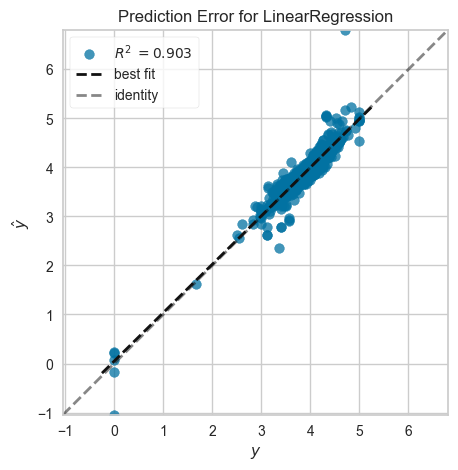


DecisionTreeRegressor
Mean Squared Error (MSE): 0.0008427672955974849
Root Mean Squared Error (RMSE): 0.029030454622645592
Mean Absolute Error (MAE): 0.004393530997306179
R^2 Score: 0.9930325476337073


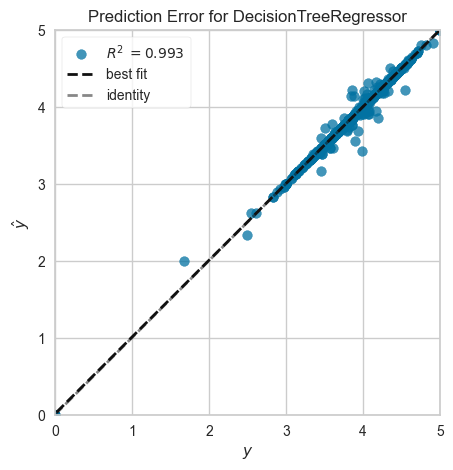

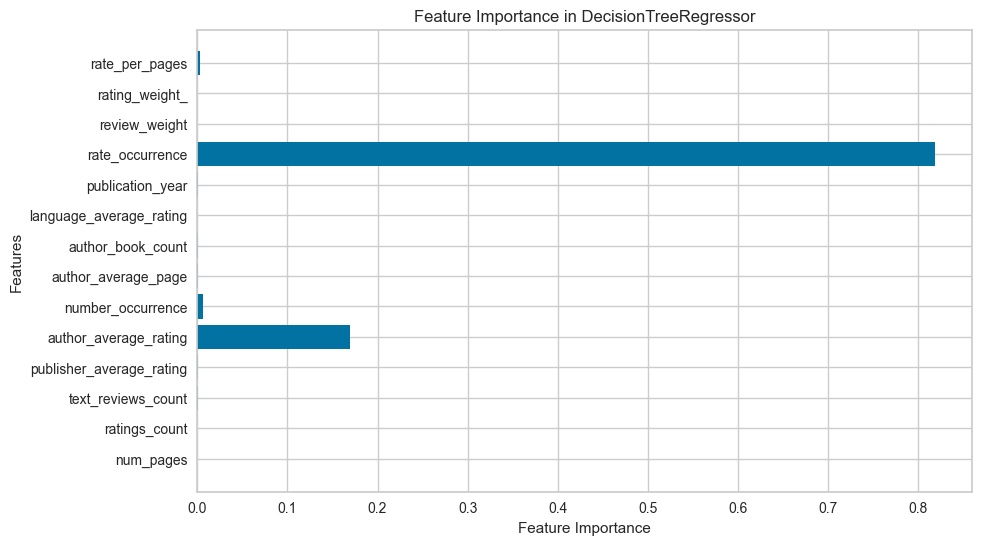


LGBMRegressor
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 8901, number of used features: 14
[LightGBM] [Info] Start training from score 3.932881
Mean Squared Error (MSE): 0.0006725079981571614
Root Mean Squared Error (RMSE): 0.025932759169767523
Mean Absolute Error (MAE): 0.007096115278040443
R^2 Score: 0.9944401408697416


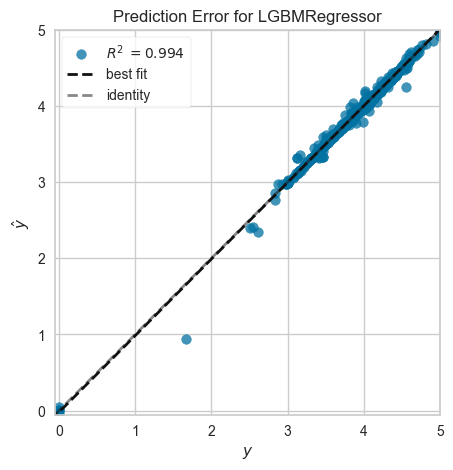

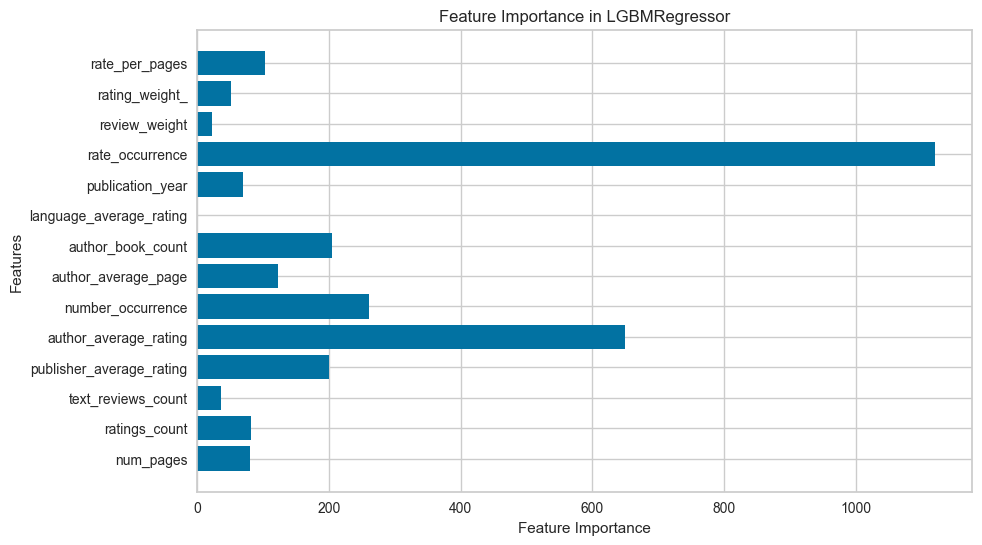


BaggingRegressor
Mean Squared Error (MSE): 0.00044156693620844715
Root Mean Squared Error (RMSE): 0.021013494145630498
Mean Absolute Error (MAE): 0.004379155435759888
R^2 Score: 0.9963494115034673


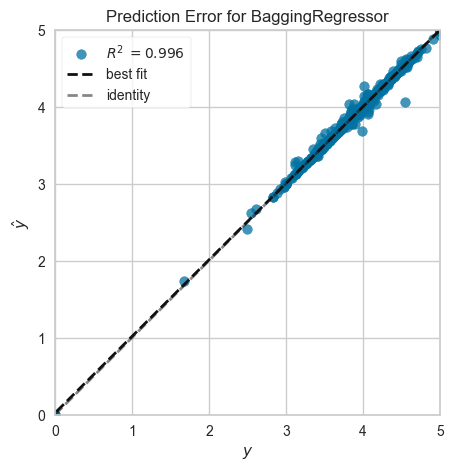


XGBRegressor
Mean Squared Error (MSE): 0.0007309968289581342
Root Mean Squared Error (RMSE): 0.027036953026517877
Mean Absolute Error (MAE): 0.007839586774283903
R^2 Score: 0.9939565932229656


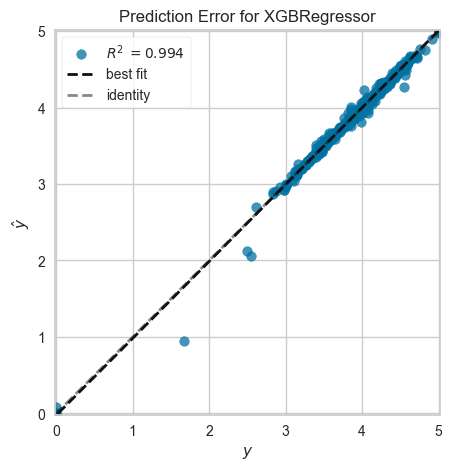

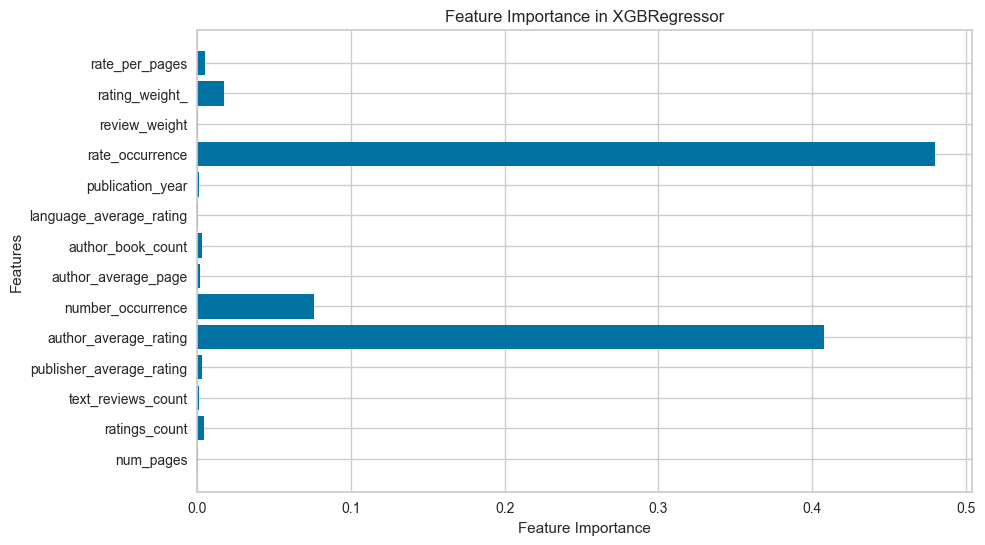


HistGradientBoostingRegressor
Mean Squared Error (MSE): 0.0010755467453936822
Root Mean Squared Error (RMSE): 0.03279552935071612
Mean Absolute Error (MAE): 0.008481010407253338
R^2 Score: 0.9911080784038507


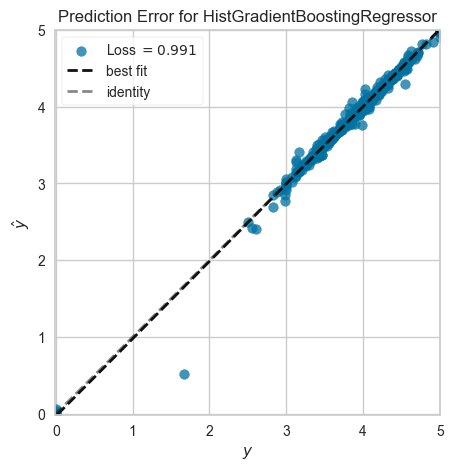

In [29]:
# Train, evaluate, and visualize each model
for name, model in models.items():
    print(f'\n{name}')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R^2 Score: {r2}')
    
    # Visualize prediction error
    fig = plt.figure(figsize=(5, 5))
    viz = PredictionError(model)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()


    # Plot feature importance if available
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        features = X_train.columns

        plt.figure(figsize=(10, 6))
        plt.barh(features, feature_importances)
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title(f'Feature Importance in {name}')
        plt.show()
